# FEATURE ENGINEERING - RETAIL DEMAND PREDICTION

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm_notebook

from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('updated_train_data.csv')
product_df = pd.read_csv('updated_product_data.csv')
store_df = pd.read_csv('updated_store_data.csv')

In [3]:
train_df.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1
1,2009-01-14,367,1111009497,1.39,0,0,20,1


In [4]:
product_df.head(2)

,UPC,MANUFACTURER_1,MANUFACTURER_2,MANUFACTURER_3,MANUFACTURER_4,MANUFACTURER_5,MANUFACTURER_6,MANUFACTURER_7,MANUFACTURER_8,MANUFACTURER_9,...,CATEGORY_3,CATEGORY_4,SUB_CATEGORY_1,SUB_CATEGORY_2,SUB_CATEGORY_3,SUB_CATEGORY_4,SUB_CATEGORY_5,SUB_CATEGORY_6,SUB_CATEGORY_7,SIZE
0,1111009477,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,15.0
1,1111009497,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,15.0


In [5]:
store_df.head(2)

,STORE_ID,ADDRESS_STATE_PROV_CODE_1,ADDRESS_STATE_PROV_CODE_2,ADDRESS_STATE_PROV_CODE_3,ADDRESS_STATE_PROV_CODE_4,MSA_CODE_1,MSA_CODE_2,MSA_CODE_3,MSA_CODE_4,MSA_CODE_5,MSA_CODE_6,MSA_CODE_7,MSA_CODE_8,MSA_CODE_9,SEG_VALUE_NAME,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,367,1,0,0,0,1,0,0,0,0,0,0,0,0,1,24721,12707
1,389,1,0,0,0,1,0,0,0,0,0,0,0,0,2,46073,24767


In [6]:
mega_df = train_df.merge(product_df, how = 'left', on = 'UPC')
mega_df = mega_df.merge(store_df, how = 'left', left_on = 'STORE_NUM', right_on = 'STORE_ID')
mega_df = mega_df.drop(columns = 'STORE_ID', axis =1)
mega_df.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MONTH,MANUFACTURER_1,MANUFACTURER_2,...,MSA_CODE_3,MSA_CODE_4,MSA_CODE_5,MSA_CODE_6,MSA_CODE_7,MSA_CODE_8,MSA_CODE_9,SEG_VALUE_NAME,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,2009-01-14,367,1111009477,1.57,0,0,13,1,1,0,...,0,0,0,0,0,0,0,1,24721,12707
1,2009-01-14,367,1111009497,1.39,0,0,20,1,1,0,...,0,0,0,0,0,0,0,1,24721,12707


In [7]:
# Converting WEEK_END_DATE column to date-time
mega_df['WEEK_END_DATE'] = pd.to_datetime(mega_df['WEEK_END_DATE'])

# Storing all the unique Dates in an array
weeks = mega_df['WEEK_END_DATE'].unique()

In [8]:
mega_df.dtypes

WEEK_END_DATE                datetime64[ns]
STORE_NUM                             int64
UPC                                   int64
BASE_PRICE                          float64
FEATURE                               int64
DISPLAY                               int64
UNITS                                 int64
MONTH                                 int64
MANUFACTURER_1                        int64
MANUFACTURER_2                        int64
MANUFACTURER_3                        int64
MANUFACTURER_4                        int64
MANUFACTURER_5                        int64
MANUFACTURER_6                        int64
MANUFACTURER_7                        int64
MANUFACTURER_8                        int64
MANUFACTURER_9                        int64
CATEGORY_1                            int64
CATEGORY_2                            int64
CATEGORY_3                            int64
CATEGORY_4                            int64
SUB_CATEGORY_1                        int64
SUB_CATEGORY_2                  

Let's define the validation_df function to create validation dataframes

In [9]:
# function to create validation data_frame
def validation_df(data, weeks, no_of_months, no_of_validations):
    
    model_set = []
    set_n = 1
    for w in range(len(weeks)-1, 0, -1):
        x_data = {}
        
        x_data['set_no'] = 'set' + str(set_n)
        x_data['train_start'] = weeks[w-3-4*no_of_months]
        x_data['train_end'] = weeks[w-4]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['valid_week'] = weeks[w-2]
        x_data['test_week'] = weeks[w]
        
        set_n += 1
        model_set.append(x_data)
        if (len(model_set)) == no_of_validations:
            break            
    
    
    datapoints = []
    
    for s in model_set:
        x = {}
        train_set = data[(data['WEEK_END_DATE'] >= s['train_start']) & (data['WEEK_END_DATE'] <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['valid_shape'] = data[data['WEEK_END_DATE'] == s['valid_week']].shape[0]
        x['test_shape'] = data[data['WEEK_END_DATE'] == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)
        
    
    df = pd.DataFrame(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df

Earlier we had concluded that the best validation strategy for current dataset is:
* to keep the size of training set = 4 weeks (1 month)
* to keep the number of validation sets = 9

In [10]:
validation_df(mega_df, weeks, no_of_months = 1, no_of_validations = 9)

,train_shape,valid_shape,test_shape,set_no,train_start,train_end,no_days_train,valid_week,test_week
0,6538,1640,1642,set1,2011-08-10,2011-08-31,28 days,2011-09-14,2011-09-28
1,6549,1632,1638,set2,2011-08-03,2011-08-24,28 days,2011-09-07,2011-09-21
2,6546,1629,1640,set3,2011-07-27,2011-08-17,28 days,2011-08-31,2011-09-14
3,6543,1640,1632,set4,2011-07-20,2011-08-10,28 days,2011-08-24,2011-09-07
4,6551,1638,1629,set5,2011-07-13,2011-08-03,28 days,2011-08-17,2011-08-31
5,6553,1631,1640,set6,2011-07-06,2011-07-27,28 days,2011-08-10,2011-08-24
6,6555,1640,1638,set7,2011-06-29,2011-07-20,28 days,2011-08-03,2011-08-17
7,6558,1637,1631,set8,2011-06-22,2011-07-13,28 days,2011-07-27,2011-08-10
8,6558,1635,1640,set9,2011-06-15,2011-07-06,28 days,2011-07-20,2011-08-03


In [11]:
# function to calculate Root-Mean-Squared-Log-Error
def get_rmsle(true, predicted):
    return np.sqrt(msle(true, predicted))


# function to return the columns on which the model is trained
def get_columns(data):
    print('\n####### The model is trained on Following Columns: ###########\n')
    print(data.columns)
    print('===============================================================')
    

# Function to train the model
# it will calculate RMLSE on train & validation set
def my_model(train_d, valid_d, model):
    
    train_x = train_d.drop(columns = ['WEEK_END_DATE', 'UPC', 'STORE_NUM', 'UNITS'])
    train_y = train_d['UNITS']
    
    valid_x = valid_d.drop(columns = ['WEEK_END_DATE', 'UPC', 'STORE_NUM', 'UNITS'])
    valid_y = valid_d['UNITS']
    
    model.fit(train_x, train_y)
    
    train_predict = RFR.predict(train_x).clip(min=0)
    valid_predict = RFR.predict(valid_x).clip(min=0)
    
    return get_rmsle(train_y, train_predict), get_rmsle(valid_y, valid_predict), train_x
    
    
# Function will extract train & validation sets using validation dataframe
# The defined model will train on each of the set using train_model function. 
# And it'll return the average RMSLE and standard deviation on validation
def train_model(df, data, model):
    
    model_results_train = []
    model_results_valid = []
    
    for r in tqdm_notebook(range(df.shape[0]), leave = False, desc = 'training_model'):
        
        row = df.iloc[r]
        train_set = data[(data['WEEK_END_DATE'] >= row['train_start']) & (data['WEEK_END_DATE'] <= row['train_end'])]
        valid_set = data[data['WEEK_END_DATE'] == row['valid_week']]
        train, valid, train_data = my_model(train_set, valid_set, model)
        model_results_train.append(train)
        model_results_valid.append(valid)
        
    return np.mean(model_results_train), np.mean(model_results_valid), train_data
    

### 1. OPTIMUM VALUE OF N_ESTIMATORS
* First of all, we will calculate the performance of the model using the default features and we will try to tune the parameters to get the best results.

* So, first we will find out the optimal value of n_estimators for the Random Forest Model and we will see the performance of the model on n_estimators value 5, 15, 25..... 245.

In [12]:
estimator_results = []

valid_df = validation_df(mega_df, weeks, no_of_months = 1, no_of_validations = 9)

for estimator in tqdm_notebook(range(5,250,10), leave = True, desc = 'estimator'):
    results = {}
    RFR = RandomForestRegressor(n_estimators = estimator, random_state =0)
    rmsle_train, rmsle_valid, train_data = train_model(valid_df, mega_df, RFR)
    results['estimators'] = estimator
    results['rmsle_train'] = rmsle_train
    results['rmsle_valid'] = rmsle_valid
    
    estimator_results.append(results)

get_columns(train_data)

estimator:   0%|          | 0/25 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]


####### The model is trained on Following Columns: ###########

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MONTH', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')


In [13]:
a = pd.DataFrame(estimator_results)
a

,estimators,rmsle_train,rmsle_valid
0,5,0.302279,0.587547
1,15,0.285166,0.563947
2,25,0.281882,0.562023
3,35,0.280082,0.559509
4,45,0.279395,0.558967
5,55,0.279021,0.558512
6,65,0.278670,0.558459
7,75,0.278396,0.557049
8,85,0.278321,0.557200
9,95,0.278196,0.557377


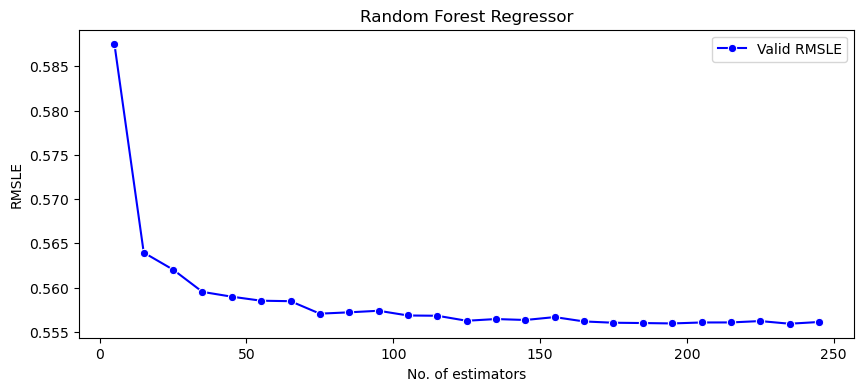

In [14]:
plt.figure(figsize = (10,4), dpi = 100)
#sns.lineplot(x = a['estimators'], y = a['rmsle_train'], marker = 'o', color = 'orange', label = 'Train RMSLE')
sns.lineplot(x = a['estimators'], y = a['rmsle_valid'], marker = 'o', color = 'blue', label = 'Valid RMSLE')
plt.title('Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('No. of estimators')
plt.legend()
plt.show()

The RMSLE is lowest on n_estimators value 125 is around **0.5562 (RMSLE)** and seems to get stable after that. So, we will keep the value of the **n_estimators = 125**.

### 2. OPTIMUM VALUE OF MAX_DEPTH
* Now, we will keep the value of n_estimators fixed as 155 and try different values of max_depth from 1, 2, ...29.

In [15]:
estimator_results = []

valid_df = validation_df(mega_df, weeks, no_of_months = 1, no_of_validations = 9)

for depth in tqdm_notebook(range(1,30,1), leave = True, desc = 'max_depth'):
    results = {}
    RFR = RandomForestRegressor(n_estimators = 125, max_depth= depth, random_state =0)
    rmsle_train, rmsle_valid, train_data = train_model(valid_df, mega_df, RFR)
    results['max_depth'] = depth
    results['rmsle_train'] = rmsle_train
    results['rmsle_valid'] = rmsle_valid
    
    estimator_results.append(results)

get_columns(train_data)

max_depth:   0%|          | 0/29 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]


####### The model is trained on Following Columns: ###########

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MONTH', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')


In [16]:
b = pd.DataFrame(estimator_results)
b

,max_depth,rmsle_train,rmsle_valid
0,1,0.919891,0.946742
1,2,0.806733,0.835589
2,3,0.716882,0.756453
3,4,0.653478,0.707551
4,5,0.604436,0.674093
5,6,0.554560,0.644815
6,7,0.514062,0.620000
7,8,0.477965,0.600625
8,9,0.445874,0.583708
9,10,0.416128,0.573705


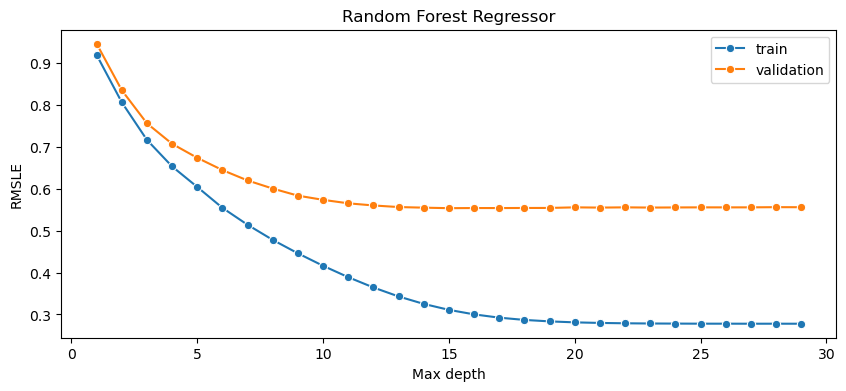

In [17]:
plt.figure(figsize = (10,4), dpi = 100)
sns.lineplot(x= b['max_depth'], y= b['rmsle_train'], marker='o',label='train');
sns.lineplot(x= b['max_depth'], y= b['rmsle_valid'], marker='o',label='validation');
plt.title('Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('Max depth')
plt.legend()
plt.show()

The RMSLE gets stable on both validation and train set after **max_depth 15** and the RMSLE is still around **0.5538**

### 3. ADD TIME BASED FEATURES
* Now, we will add some Time based features to the data like year of the transaction, month, day, day_of_year, week, quarter.

* And we will once again check the performace of the model for different max_depth 1 to 29 and will decide whether we have selected the right value of max_depth or not.

In [18]:
# year
mega_df['year']  = mega_df['WEEK_END_DATE'].dt.year
# day
mega_df['day'] = mega_df['WEEK_END_DATE'].dt.day
# day_of year
mega_df['day_of_year'] = mega_df['WEEK_END_DATE'].dt.dayofyear
# week 
mega_df["week"] = mega_df['WEEK_END_DATE'].dt.week
# quarter
mega_df["quarter"] = mega_df['WEEK_END_DATE'].dt.quarter

In [19]:
depth_results = []

valid_df = validation_df(mega_df, weeks, no_of_months = 1, no_of_validations = 9)

for depth in tqdm_notebook(range(1,30,1), leave = True, desc = 'max_depth'):
    results = {}
    RFR = RandomForestRegressor(n_estimators = 125, max_depth= depth, random_state =0)
    rmsle_train, rmsle_valid, train_data = train_model(valid_df, mega_df, RFR)
    results['max_depth'] = depth
    results['rmsle_train'] = rmsle_train
    results['rmsle_valid'] = rmsle_valid
    
    depth_results.append(results)

get_columns(train_data)

max_depth:   0%|          | 0/29 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

training_model:   0%|          | 0/9 [00:00<?, ?it/s]


####### The model is trained on Following Columns: ###########

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MONTH', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'year', 'day',
       'day_of_year', 'week', 'quarter'],
      dtype='object')


In [20]:
c = pd.DataFrame(depth_results)
c

,max_depth,rmsle_train,rmsle_valid
0,1,0.919891,0.946742
1,2,0.806733,0.835244
2,3,0.716883,0.756769
3,4,0.653285,0.707083
4,5,0.604267,0.672977
5,6,0.554080,0.643927
6,7,0.512273,0.619206
7,8,0.474466,0.600611
8,9,0.439602,0.585839
9,10,0.406566,0.575310


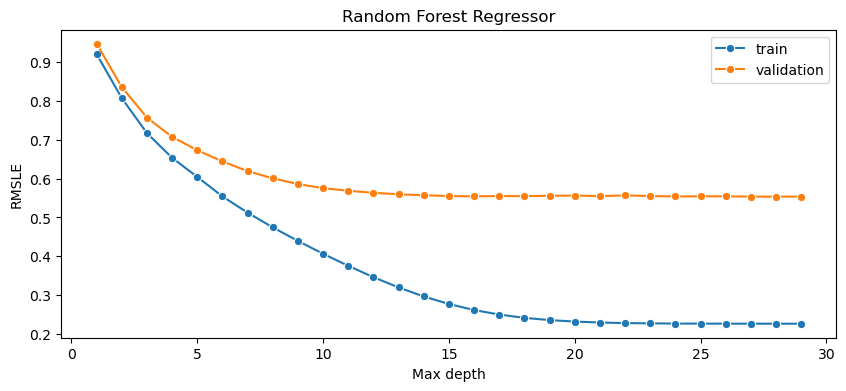

In [21]:
plt.figure(figsize = (10,4), dpi = 100)
sns.lineplot(x= c['max_depth'], y= c['rmsle_train'], marker='o',label='train');
sns.lineplot(x= c['max_depth'], y= c['rmsle_valid'], marker='o',label='validation');
plt.title('Random Forest Regressor')
plt.ylabel('RMSLE')
plt.xlabel('Max depth')
plt.legend()
plt.show()

So, we can still see that the value of **RMSLE (0.5550)** on validation set is getting stable after the **max_depth 15**. Now, we will keep on adding the new features to the data and check if it is improving the results or not.



### 4. UNIQUE STORE FEATURES

FOR EACH STORE_ID WE WILL FIND

* **UNIQUE NUMBER OF MANUFACTURERS**
For, each of the stores we will find out the number of unique number of manufactures as a feature. We are assumuing that more number of manufactures will give more options to the customers and will impact the sales.
We will have to use the original train_data and product_data to calculate this as we have encoded this feature in mega_df during the pre-processing step.

* **UNIQUE NUMBER OF CATEGORY AND SUB_CATEGORIES THEY HAVE**

Similarly, we will find out the unique number of categories and sub categories that a particular store has.


In [22]:
original_train_df = pd.read_csv('train.csv', usecols= ['STORE_NUM','UPC'])
original_product_df = pd.read_csv('product_data.csv')

In [23]:
original_product_df.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML
4,1111038080,PL ANTSPTC SPG MNT MTHWS,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [24]:
original_train_df = original_train_df.merge(original_product_df, how = 'left', on = 'UPC')

In [25]:
# Now, we will create another dataframe unique_store_data
# We will group the data by STORE_NUM and find unique values of the features 'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY'
unique_store_df = original_train_df.groupby('STORE_NUM')[['MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY']].nunique().reset_index()

In [26]:
# rename the columns of the dataframe 'unique_store_data'
unique_store_df.columns = ['STORE_NUM', 'U_MANUFACTURER', 'U_CATEGORY', 'U_SUB_CATEGORY']

In [27]:
unique_store_df.head(2)

,STORE_NUM,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY
0,367,4,3,5
1,389,7,4,6


In [28]:
mega_df = mega_df.merge(unique_store_df, how = 'left', on = 'STORE_NUM')

In [29]:
mega_df.head()

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MONTH,MANUFACTURER_1,MANUFACTURER_2,...,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS,year,day,day_of_year,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY
0,2009-01-14,367,1111009477,1.57,0,0,13,1,1,0,...,24721,12707,2009,14,14,3,1,4,3,5
1,2009-01-14,367,1111009497,1.39,0,0,20,1,1,0,...,24721,12707,2009,14,14,3,1,4,3,5
2,2009-01-14,367,1111085319,1.88,0,0,14,1,1,0,...,24721,12707,2009,14,14,3,1,4,3,5
3,2009-01-14,367,1111085345,1.88,0,0,29,1,1,0,...,24721,12707,2009,14,14,3,1,4,3,5
4,2009-01-14,367,1111085350,1.98,0,0,35,1,1,0,...,24721,12707,2009,14,14,3,1,4,3,5


In [30]:
# train a model with the new features.
RFR = RandomForestRegressor(max_depth=15, n_estimators=125, random_state =0)

valid_df = validation_df(mega_df, weeks, no_of_months=1, no_of_validations= 9)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, mega_df, RFR)

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

In [31]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.27571477566191394
RMSLE on validation set: 0.5531365021075761


In [32]:
data_train.columns

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MONTH', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'year', 'day',
       'day_of_year', 'week', 'quarter', 'U_MANUFACTURER', 'U_CATEGORY',
       'U_SUB_CATEGORY'],
      dtype='object')

Here, On the validation set the  **RMSLE is now 0.5531**

### 5. GET LAG FEATURES
Now, we will create the lag features, which will be the number of units ordered of the same product from the same store at exactly one year ago.


In [33]:
# define a function that will return calculate the units sold number of a particular product from a particular store.
# We need to calculate this for 52 Weeks or 1 Year

def get_lag_features(data, no_of_weeks = 1, return_series = False):
    
    data_copy = data.copy()
    sample_1 = data_copy[['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS']]
    data_copy['NEW_DATE'] = data_copy['WEEK_END_DATE'] + timedelta(days = no_of_weeks*7)
    data_copy['PAST_DATE'] = data_copy['WEEK_END_DATE']
    
    sample_2 = data_copy[['NEW_DATE', 'PAST_DATE', 'STORE_NUM', 'UPC', 'UNITS']]
    final = sample_1.merge(sample_2, how = 'left', left_on = ['WEEK_END_DATE', 'STORE_NUM', 'UPC'], right_on = ['NEW_DATE', 'STORE_NUM', 'UPC'])
    final = final.drop(columns = 'NEW_DATE')
    final.fillna(0, inplace = True)
    
    if return_series:
        return final['UNITS_y']
    else: 
        return final

In [34]:
# Let's verify the function is correct or not.
# In the following dataframe, We have UNITS_x as the units sold on the transaction data and UNITS_y as the units sold on the PAST_DATE

get_lag_features(mega_df, no_of_weeks = 8)

,WEEK_END_DATE,STORE_NUM,UPC,UNITS_x,PAST_DATE,UNITS_y
0,2009-01-14,367,1111009477,13,0,0.0
1,2009-01-14,367,1111009497,20,0,0.0
2,2009-01-14,367,1111085319,14,0,0.0
3,2009-01-14,367,1111085345,29,0,0.0
4,2009-01-14,367,1111085350,35,0,0.0
...,...,...,...,...,...,...
232260,2011-09-28,29159,7192100336,32,2011-08-03 00:00:00,16.0
232261,2011-09-28,29159,7192100337,31,2011-08-03 00:00:00,10.0
232262,2011-09-28,29159,7192100339,23,2011-08-03 00:00:00,13.0
232263,2011-09-28,29159,7797502248,8,2011-08-03 00:00:00,7.0


In [35]:
#  create a feature UNITS BEFORE 52_WEEK
mega_df['UNITS_BEFORE_52WEEK'] = get_lag_features(mega_df, no_of_weeks= 52, return_series= True)

In [36]:
# train the model with the new feature

RFR = RandomForestRegressor(max_depth=15, n_estimators=125, random_state = 0)

valid_df = validation_df(mega_df, weeks, no_of_months=1, no_of_validations= 9)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, mega_df, RFR)

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

In [37]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.25436711248250216
RMSLE on validation set: 0.5718271268635867


We can see a substantial increase in the RMSLE on the validaiton set. **RMSLE is 0.5718 now**

### 6. DIFFERENCE IN PRICE FROM LAST WEEK
This will be our new feature. Whether the increase/decrease in price from the last week makes any difference to the model or not.



In [38]:
# get the price difference
mega_df['price_difference'] = mega_df['BASE_PRICE'] - mega_df.groupby(['STORE_NUM', 'UPC'])['BASE_PRICE'].shift(1)

In [39]:
# let's verify we have calculated the right price difference or not
mega_df.loc[(mega_df['STORE_NUM'] == 367) & (mega_df['UPC'] == 1111009477),['STORE_NUM', 'UPC', 'BASE_PRICE', 'price_difference','UNITS']].head(10)

,STORE_NUM,UPC,BASE_PRICE,price_difference,UNITS
0,367,1111009477,1.57,NaN,13
1640,367,1111009477,1.57,0.00,24
3276,367,1111009477,1.36,-0.21,7
4912,367,1111009477,1.38,0.02,12
6552,367,1111009477,1.50,0.12,16
8178,367,1111009477,1.49,-0.01,21
9813,367,1111009477,1.49,0.00,11
11426,367,1111009477,1.49,0.00,10
13039,367,1111009477,1.39,-0.10,13
14676,367,1111009477,1.48,0.09,13


In [40]:
# fill the null values in the price difference with 0
mega_df['price_difference'].fillna(0,inplace=True)

In [41]:
RFR = RandomForestRegressor(max_depth=15, n_estimators=125, random_state = 0)

valid_df = validation_df(mega_df, weeks, no_of_months= 1, no_of_validations= 9)

rmsle_train, rmsle_valid, data_train = train_model(valid_df, mega_df, RFR)

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

In [42]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.2572474524692946
RMSLE on validation set: 0.5722740445887792


On the validaiton set **RMSLE is 0.5722** now

### 8. AVERAGE BEFORE 2 MONTH
* As we have one week gap between the training period and the validation set so for each store and product combination we will calculate the average units sold in 2 months before 1 week.
* In simple terms, the average number of units sold from 7 days to 63 days ago
* Let's see is this feature useful to us or not.

In [43]:
# make 2 columns one with 63 days difference from the week end date and another with 7 days difference
mega_df['2_MONTH_BEFORE'] = mega_df['WEEK_END_DATE'] - timedelta(days=63)
mega_df['1_WEEK_BEFORE'] = mega_df['WEEK_END_DATE'] - timedelta(days=7)

In [44]:
mega_df[['WEEK_END_DATE', '2_MONTH_BEFORE', '1_WEEK_BEFORE']].tail()

,WEEK_END_DATE,2_MONTH_BEFORE,1_WEEK_BEFORE
232260,2011-09-28,2011-07-27,2011-09-21
232261,2011-09-28,2011-07-27,2011-09-21
232262,2011-09-28,2011-07-27,2011-09-21
232263,2011-09-28,2011-07-27,2011-09-21
232264,2011-09-28,2011-07-27,2011-09-21


In [45]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
# calculate the average units in the period
def get_average_units(x):
    data_2month = mega_df[(mega_df['WEEK_END_DATE'] <= x['1_WEEK_BEFORE']) & (mega_df['WEEK_END_DATE'] >= x['2_MONTH_BEFORE']) & (mega_df['STORE_NUM'] == x['STORE_NUM']) & (mega_df['UPC'] == x['UPC']) ]
    return data_2month.UNITS.mean() 

In [46]:
mega_df['AVERAGE_UNITS_IN_2_MONTH'] = mega_df.progress_apply(get_average_units,axis=1)

  0%|          | 0/232265 [00:00<?, ?it/s]

In [47]:
mega_df['AVERAGE_UNITS_IN_2_MONTH'].fillna(0,inplace=True)

In [48]:
new_data = mega_df.drop(columns=['2_MONTH_BEFORE','1_WEEK_BEFORE'])

RFR = RandomForestRegressor(max_depth=15, n_estimators=125, random_state = 0)

valid_df = validation_df(new_data, weeks, no_of_months=1, no_of_validations=9)

rmsle_train, rmsle_valid, data_train = train_model(valid_df,new_data, RFR)

training_model:   0%|          | 0/9 [00:00<?, ?it/s]

In [49]:
print('RMSLE on train set: ', rmsle_train)
print('RMSLE on validation set:', rmsle_valid)

RMSLE on train set:  0.21751576519534693
RMSLE on validation set: 0.490958185172677


In [50]:
data_train.columns

Index(['BASE_PRICE', 'FEATURE', 'DISPLAY', 'MONTH', 'MANUFACTURER_1',
       'MANUFACTURER_2', 'MANUFACTURER_3', 'MANUFACTURER_4', 'MANUFACTURER_5',
       'MANUFACTURER_6', 'MANUFACTURER_7', 'MANUFACTURER_8', 'MANUFACTURER_9',
       'CATEGORY_1', 'CATEGORY_2', 'CATEGORY_3', 'CATEGORY_4',
       'SUB_CATEGORY_1', 'SUB_CATEGORY_2', 'SUB_CATEGORY_3', 'SUB_CATEGORY_4',
       'SUB_CATEGORY_5', 'SUB_CATEGORY_6', 'SUB_CATEGORY_7', 'SIZE',
       'ADDRESS_STATE_PROV_CODE_1', 'ADDRESS_STATE_PROV_CODE_2',
       'ADDRESS_STATE_PROV_CODE_3', 'ADDRESS_STATE_PROV_CODE_4', 'MSA_CODE_1',
       'MSA_CODE_2', 'MSA_CODE_3', 'MSA_CODE_4', 'MSA_CODE_5', 'MSA_CODE_6',
       'MSA_CODE_7', 'MSA_CODE_8', 'MSA_CODE_9', 'SEG_VALUE_NAME',
       'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'year', 'day',
       'day_of_year', 'week', 'quarter', 'U_MANUFACTURER', 'U_CATEGORY',
       'U_SUB_CATEGORY', 'UNITS_BEFORE_52WEEK', 'price_difference',
       'AVERAGE_UNITS_IN_2_MONTH'],
      dtype='object')

* The last feature that we added has made significant improvement in the RMSLE score on the validation data.
* The **RMSLE is now 0.4909**

Let's save this dataset with new and final features in a new .CSV file.

In [51]:
mega_df.shape

(232265, 58)

In [52]:
mega_df.to_csv('final_data.csv', index= False)